In [2]:
import csv
from typing import Optional

import arrow
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.src.layers import LSTM, Dropout, Dense
from pandas import DatetimeIndex
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 可视化结果（如果需要）
import matplotlib.pyplot as plt
import os
import pathlib
import xml.etree.ElementTree as ET
import xarray as xr
import codecs
import datetime

# 先从海浪数据中提取出经纬度，时间，风，海浪高度
# 解析单个文件，并存于字典内
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler


In [35]:

def batch_get_realdata(file_full_path: str, split_hours=72, issue_hours_steps: int = 12) -> pd.DataFrame:
    """
        TODO:[-] 25-04-23 生成实况训练数据集
        从指定文件批量获取时间数据并以dataframe的形式返回
    :param file_full_path:
    :return:
    """

    """
        eg: csv文件样例:
                        time	longitude	latitude	WS	YBG
                        202401010000
                        YYYYMMDDHHmm
    """
    list_series = []
    merge_dict = {}
    if pathlib.Path(file_full_path).exists():
        # ds: xr.Dataset = xr.open_dataset(file_full_path)
        df: pd.DataFrame = pd.read_csv(file_full_path)
        """读取指定路径的浮标处理后的一年的数据"""
        # 通过起止时间找到对应的index，然后每次的发布时间间隔步长为12h

        # step1: 生成2024年一年的时间步长为1hour的时间索引集合
        # TODO:[-] 25-05-12 注意此部分修改起止时间 local time -> utc time
        start_time = '2024-01-01 00:00:00'
        end_time = '2024-12-31 23:00:00'
        start_time_utc = '2023-12-31 16:00:00'
        end_time_utc = '2024-12-31 15:00:00'
        time_series = pd.date_range(start=start_time, end=end_time, freq='H')

        # 将time列的内容从int64 => str
        df['time'] = df['time'].astype(str)
        df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
        # step2: 将 time列设置为index，并将index替换为标准时间集合
        df.set_index('time', inplace=True)
        # TODO:[-] 25-05-12 注意直接重设index会造成所有数据为 nan 的情况。 解决办法：先创建新的utc_times 再设置为索引列
        # ValueError: Length of values (8784) does not match length of index (8887)

        df_reindexed = df.reindex(time_series)
        utc_times = pd.date_range(start=start_time_utc, end=end_time_utc, freq='H', tz='utc')
        df_reindexed['utc_times'] = utc_times
        df_reindexed = df_reindexed.set_index('utc_times')
        # 此处不需要再删除 time了，因为 index 已经 utc_times -> index了
        # df_reindexed = df_reindexed.drop('time', axis=1)
        df_reindexed.index.name = 'time'

        # step3: 生成12小时为间隔的时间数组
        freq_str: str = f'{issue_hours_steps}H'
        start_time_split_utc: str = '2024-01-01 00:00:00'
        end_time_split_utc: str = '2024-12-31 23:00:00'
        issue_dt_series = pd.date_range(start=start_time_split_utc, end=end_time_split_utc, freq=freq_str, tz='utc')

        for temp_time in issue_dt_series:
            temp_index: int = df_reindexed.index.get_loc(temp_time)
            val_series = df_reindexed[temp_index:temp_index + split_hours]
            list_series.append(val_series)
        # TODO:[-] 25-04-24 此处做重新修改，拼接成一个dataframe

        for temp_time in issue_dt_series:
            dt_str: str = temp_time.strftime('%Y%m%d%H%M%S')
            temp_index: int = df_reindexed.index.get_loc(temp_time)
            val_series = df_reindexed[temp_index:temp_index + split_hours]
            # 此处改为只取 'WS' 列
            # TODO:[-] 25-04-24 住一次此处需要将每一个 series的index索引重置为 [0,71]
            merge_dict[dt_str] = val_series['WS'].reset_index(drop=True)
            # list_series.append(val_series)
    df = pd.DataFrame.from_dict(merge_dict)
    # TODO:[-] 25-05-11 注意此处的 columns 为 字符串，需要将 str -> datetime
    df.columns = pd.to_datetime(df.columns)
    return df



In [36]:

def get_test_array(test_read_path: str, training_read_path: str, issue_times_index: DatetimeIndex):
    """
        分别读取测试数据集以及实况数据集并进行训练
    :param test_read_path:
    :param training_read_path:
    :return:
    """
    if pathlib.Path(test_read_path).exists() and pathlib.Path(training_read_path).exists():
        df_test: pd.DataFrame = pd.read_csv(test_read_path)
        u_data_dict = {}
        v_data_dict = {}
        # 读取的预报风场——测试训练集 在 df 中是通过 xxx_u与 xxx_v 的形式进行存储
        # TODO:[-] 25-04-28 u 与 v 每个共613组预报数据
        for col_name in df_test.columns:
            try:
                col_vector = df_test[col_name]
                # yyyymmddhhss
                dt_temp_str: str = col_name.split('_')[0]
                # u or v
                var_temp_str: str = col_name.split('_')[1]
                if var_temp_str == 'u':
                    # u_data_dict[dt_temp_str] = col_vector.tolist()
                    u_data_dict[dt_temp_str] = col_vector
                elif var_temp_str == 'v':
                    # v_data_dict[dt_temp_str] = col_vector.tolist()
                    v_data_dict[dt_temp_str] = col_vector
                print(f'当前列:{col_name}处理成功~')
            except Exception as e:
                print(f'当前列:{col_name}处理错误!')
        # # step2: 将字典统一转换为二维数组
        # result_u_array = [val for key, val in u_data_dict.items()]
        # result_v_array = [val for key, val in v_data_dict.items()]
        # return [result_u_array, result_v_array]
        df_u = pd.DataFrame.from_dict(u_data_dict)
        df_v = pd.DataFrame.from_dict(v_data_dict)
        # 将时间字符串=>datetime
        df_u.columns = pd.to_datetime(df_u.columns)
        df_v.columns = pd.to_datetime(df_v.columns)
        # TODO:[*] 25-04-29
        # 需要根据起止时间及时间步长，生成对应的时间索引，并将该时间索引作为标准索引
        # 注意： reindex 后会返回一个新的 DataFrame，并不会修改原始df
        df_u = df_u.reindex(columns=issue_times_index)
        df_v = df_v.reindex(columns=issue_times_index)
        return df_u, df_v
        # pass
    return None



In [37]:
read_path: str = r'Z:\WIND\GRAPES\2024'
out_put_path: str = r'./data'
out_put_file_path: str = str(pathlib.Path(out_put_path) / 'GRAPES_2024_24')
lat: float = 39.5003
lng: float = 120.59533
# TODO:[*] 25-04-29 根据起止时间，时间步长为12h，生成发布时间index
start_time = '2024-01-01 00:00:00'
end_time = '2024-12-31 23:00:00'
issue_times_index = pd.date_range(start=start_time, end=end_time, freq='12h')
# step1: 提取数据集
df_u, df_v = get_test_array(r'G:\05DATA\01TRAINING_DATA\WIND\merge.csv',
                            r'G:\05DATA\01TRAINING_DATA\FUB\MF01001\2024_local.csv', issue_times_index)
read_file_full_path: str = r'G:\05DATA\01TRAINING_DATA\FUB\MF01001\2024_local.csv'
#  生成一年的 365*2 =730 个 ws,ybg -> 只取 ws
# 注意实况 shape : (72,732)
df_ws = batch_get_realdata(read_file_full_path)
"""shape:(72,732)"""
df_ws_subset = df_ws.iloc[:25, :]

当前列:Unnamed: 0.10处理错误!
当前列:20240101000000_u处理成功~
当前列:20240101000000_v处理成功~
当前列:20240101120000_u处理成功~
当前列:20240101120000_v处理成功~
当前列:20240102000000_u处理成功~
当前列:20240102000000_v处理成功~
当前列:20240102120000_u处理成功~
当前列:20240102120000_v处理成功~
当前列:20240103000000_u处理成功~
当前列:20240103000000_v处理成功~
当前列:20240103120000_u处理成功~
当前列:20240103120000_v处理成功~
当前列:20240104000000_u处理成功~
当前列:20240104000000_v处理成功~
当前列:20240104120000_u处理成功~
当前列:20240104120000_v处理成功~
当前列:20240105000000_u处理成功~
当前列:20240105000000_v处理成功~
当前列:20240105120000_u处理成功~
当前列:20240105120000_v处理成功~
当前列:20240106000000_u处理成功~
当前列:20240106000000_v处理成功~
当前列:20240106120000_u处理成功~
当前列:20240106120000_v处理成功~
当前列:20240107000000_u处理成功~
当前列:20240107000000_v处理成功~
当前列:20240107120000_u处理成功~
当前列:20240107120000_v处理成功~
当前列:20240108000000_u处理成功~
当前列:20240108000000_v处理成功~
当前列:20240108120000_u处理成功~
当前列:20240108120000_v处理成功~
当前列:20240109000000_u处理成功~
当前列:20240109000000_v处理成功~
当前列:20240109120000_u处理成功~
当前列:20240109120000_v处理成功~
当前列:20240110000000_u处理成功~
当前列:20240110000

C:\Users\evase\AppData\Local\Temp\ipykernel_22172\2096832180.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_series = pd.date_range(start=start_time, end=end_time, freq='H')
C:\Users\evase\AppData\Local\Temp\ipykernel_22172\2096832180.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utc_times = pd.date_range(start=start_time_utc, end=end_time_utc, freq='H', tz='utc')
C:\Users\evase\AppData\Local\Temp\ipykernel_22172\2096832180.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  issue_dt_series = pd.date_range(start=start_time_split_utc, end=end_time_split_utc, freq=freq_str, tz='utc')


In [38]:
df_ws_subset.iloc[:,0]

0      4.0
1      5.3
2      6.4
3      0.0
4      8.1
5      9.3
6     10.6
7      9.8
8     11.3
9     11.9
10    12.2
11    11.8
12    12.8
13    11.1
14     9.9
15     9.3
16    10.4
17    10.4
18    10.8
19    10.1
20     9.4
21     8.6
22     7.5
23     7.4
24     4.5
Name: 2024-01-01 00:00:00, dtype: float64

In [24]:
df_ws_subset = df_ws_subset.where((df_ws_subset > min) & (df_ws_subset < max))

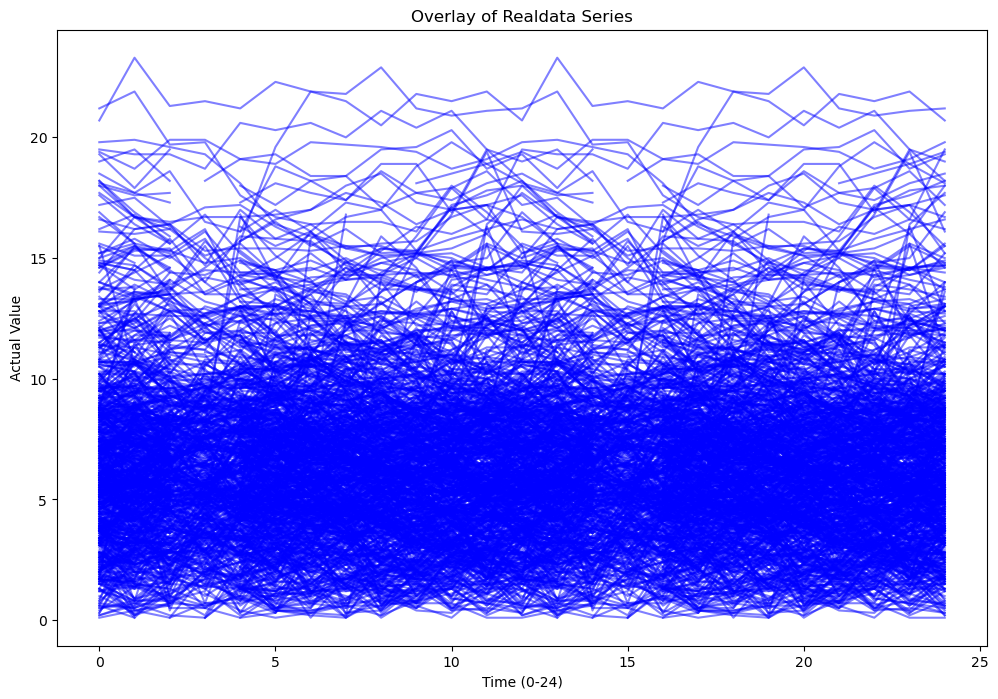

In [14]:
import matplotlib.pyplot as plt

# 假设 df_ws_forecast 是你的 DataFrame，形状为 (25, 732)
# x 轴取 0 ~ 24
x = range(25)

plt.figure(figsize=(12, 8))

# 遍历所有列（如果你只需要绘制 731 列，用 df_ws_forecast.columns[:731]）
for col in df_ws_subset.columns:
    plt.plot(x, df_ws_subset[col], color='blue', alpha=0.5)  # alpha 调整透明度，可以根据需要调整

plt.xlabel('Time (0-24)')
plt.ylabel('Actual Value')
plt.title('Overlay of Realdata Series')
plt.show()

In [26]:
df_ws_forecast = np.sqrt(df_u ** 2 + df_v ** 2)

In [10]:
min = 0
max = 30
df_ws_forecast = df_ws_forecast.where((df_ws_forecast > min) & (df_ws_forecast < max))

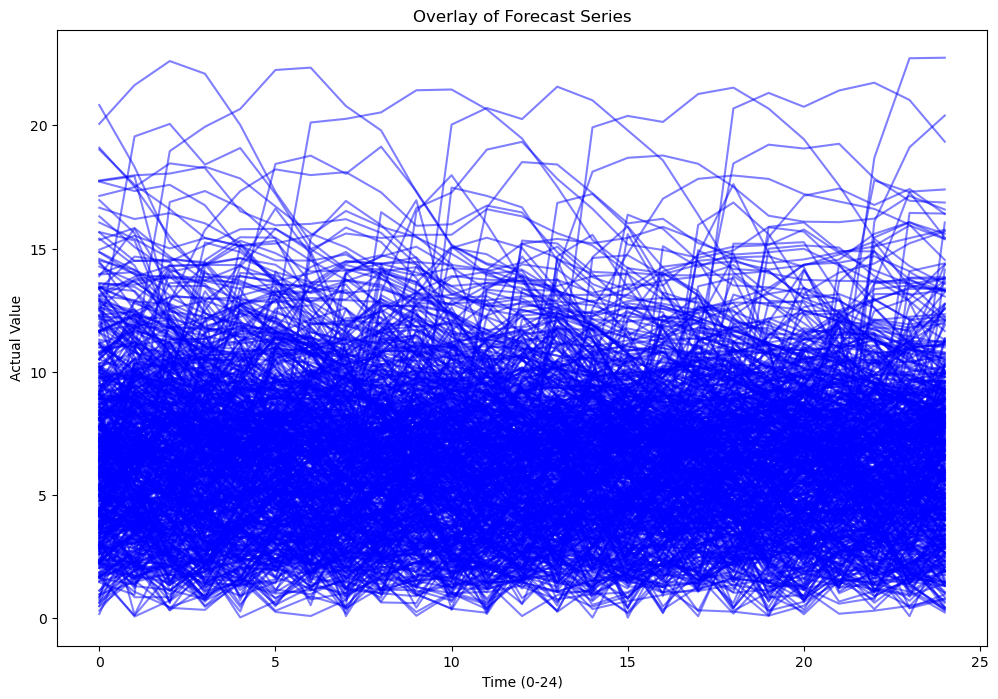

In [11]:
# 假设 df_ws_forecast 是你的 DataFrame，形状为 (25, 732)
# x 轴取 0 ~ 24
x = range(25)

plt.figure(figsize=(12, 8))

# 遍历所有列（如果你只需要绘制 731 列，用 df_ws_forecast.columns[:731]）
for col in df_ws_forecast.columns:
    plt.plot(x, df_ws_forecast[col], color='blue', alpha=0.5)  # alpha 调整透明度，可以根据需要调整

plt.xlabel('Time (0-24)')
plt.ylabel('Actual Value')
plt.title('Overlay of Forecast Series')
plt.show()

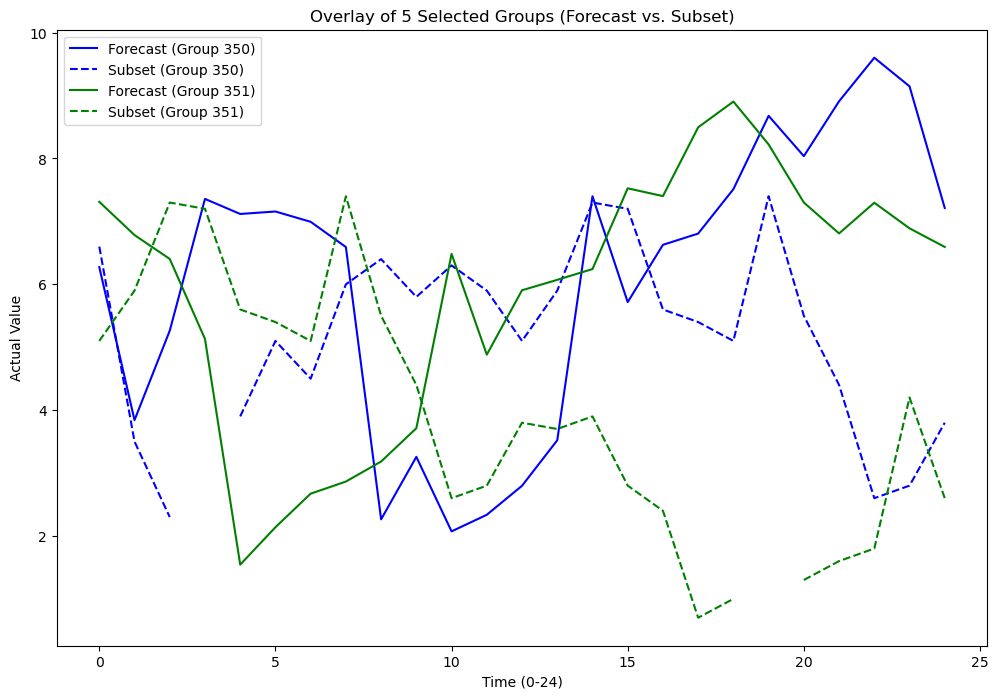

In [22]:
# 定义需要绘制的五组列索引
group_indices = [350, 351]  # 可根据需要修改为实际列索引

# 定义五种颜色
colors = ['blue', 'green', 'red', 'orange', 'purple']

# x 轴取值：由于 df_ws_forecast 的形状为 (25, 732)，
# 表示每列有 25 个数据点，x 轴范围为 0 ~ 24
x = range(df_ws_forecast.shape[0])

plt.figure(figsize=(12, 8))

# 对每一组（同一列）进行绘制
for i, col in enumerate(group_indices):
    # 从 df_ws_forecast 中取出第 col 列数据，用实线显示
    forecast_values = df_ws_forecast.iloc[:, col]
    # 从 df_ws_subset 中取出对应的第 col 列数据，用虚线显示
    subset_values = df_ws_subset.iloc[:, col]
    
    # 绘制实线：预测数据
    plt.plot(x, forecast_values, color=colors[i], linestyle='-', 
             label=f'Forecast (Group {col})')
    
    # 绘制虚线：实际数据
    plt.plot(x, subset_values, color=colors[i], linestyle='--', 
             label=f'Subset (Group {col})')

plt.xlabel('Time (0-24)')
plt.ylabel('Actual Value')
plt.title('Overlay of 5 Selected Groups (Forecast vs. Subset)')
plt.legend()
plt.show()

In [19]:
df_ws_subset.iloc[:,0]

0      4.0
1      5.3
2      6.4
3      NaN
4      8.1
5      9.3
6     10.6
7      9.8
8     11.3
9     11.9
10    12.2
11    11.8
12    12.8
13    11.1
14     9.9
15     9.3
16    10.4
17    10.4
18    10.8
19    10.1
20     9.4
21     8.6
22     7.5
23     7.4
24     4.5
Name: 2024-01-01 00:00:00, dtype: float64

In [20]:
df_ws_forecast.iloc[:,0]

0      2.923878
1      6.530825
2      8.889989
3      9.039523
4      8.654149
5      9.039949
6      8.168639
7      6.405967
8      3.743547
9      4.216596
10     4.505083
11     2.498757
12     1.197143
13     3.043036
14     4.698903
15     5.677125
16     5.207698
17     3.135598
18     5.300126
19     7.344073
20     7.491592
21     8.000455
22     9.339854
23    10.532655
24    11.210040
Name: 2024-01-01 00:00:00, dtype: float64